In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

SEED=0

In [10]:
data = pd.read_csv("creditcard.csv", header=0)
#data.head()

In [11]:
print("Duplicates", data.duplicated().sum())
data = data.drop_duplicates()
print("Rows {}, Columns {}".format(data.shape[0], data.shape[1]))

Duplicates 1081
Rows 283726, Columns 31


In [12]:
#Convert All majority class to 1 and minority to -1 for oneclass svm
data['Class'] = data['Class'].replace({0: 1, 1: -1})
#data['Class'].unique()
data['Class'].value_counts()

Class
 1    283253
-1       473
Name: count, dtype: int64

In [13]:
x_majority = data[data["Class"]==1]
y_majority = x_majority["Class"]
x_majority = x_majority.drop(columns=["Class"])
x_minority = data[data["Class"]==-1]
y_minority = x_minority["Class"]
x_minority = x_minority.drop(columns=["Class"])

In [14]:
X_train, X_test, y_train, y_test = train_test_split( x_majority, y_majority, test_size=0.2, random_state=SEED )
X_test = pd.concat([X_test,x_minority],axis=0)
y_test = pd.concat([y_test,y_minority],axis=0)


In [19]:
print(X_train.shape)

(226602, 30)


In [17]:
%%time
iforest = IsolationForest()
param_grid = {'n_estimators': [10,100,200],'max_samples' : ["auto"],'contamination': ['auto'],'random_state' : [SEED]}
grid_best_iforest = GridSearchCV(iforest, param_grid=param_grid, scoring='f1',return_train_score=True,verbose=3,n_jobs=-1,cv=2)
grid_search_iforest =grid_best_iforest.fit(X_train,np.ones(X_train.shape[0],dtype=np.int8))
print(grid_search_iforest.best_params_)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 2/2] END contamination=auto, max_samples=auto, n_estimators=10, random_state=0;, score=(train=0.969, test=0.970) total time=   0.3s
[CV 1/2] END contamination=auto, max_samples=auto, n_estimators=10, random_state=0;, score=(train=0.946, test=0.946) total time=   0.3s
[CV 1/2] END contamination=auto, max_samples=auto, n_estimators=100, random_state=0;, score=(train=0.979, test=0.979) total time=   2.1s
[CV 2/2] END contamination=auto, max_samples=auto, n_estimators=100, random_state=0;, score=(train=0.981, test=0.982) total time=   2.2s
[CV 2/2] END contamination=auto, max_samples=auto, n_estimators=200, random_state=0;, score=(train=0.983, test=0.983) total time=   4.0s
[CV 1/2] END contamination=auto, max_samples=auto, n_estimators=200, random_state=0;, score=(train=0.980, test=0.980) total time=   4.1s
{'contamination': 'auto', 'max_samples': 'auto', 'n_estimators': 200, 'random_state': 0}
CPU times: user 313 ms, sys: 141

In [22]:
iforest_act = IsolationForest(contamination="auto",max_samples="auto",n_estimators=200,random_state=SEED)
iforest_act.fit(X_train)
y_pred = iforest_act.decision_function(X_test)
y_pred = [-1 if s < 0 else 1 for s in y_pred]
print("Accuracy Score: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.2f}%".format(f1_score(y_test, y_pred) * 100))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

Accuracy Score: 96.50%
F1 Score: 98.20%
Confusion Matrix:
 [[  394    79]
 [ 1922 54729]]
              precision    recall  f1-score   support

          -1       0.17      0.83      0.28       473
           1       1.00      0.97      0.98     56651

    accuracy                           0.96     57124
   macro avg       0.58      0.90      0.63     57124
weighted avg       0.99      0.96      0.98     57124



Confusion matrix:
[[  394    79]
 [ 1922 54729]]


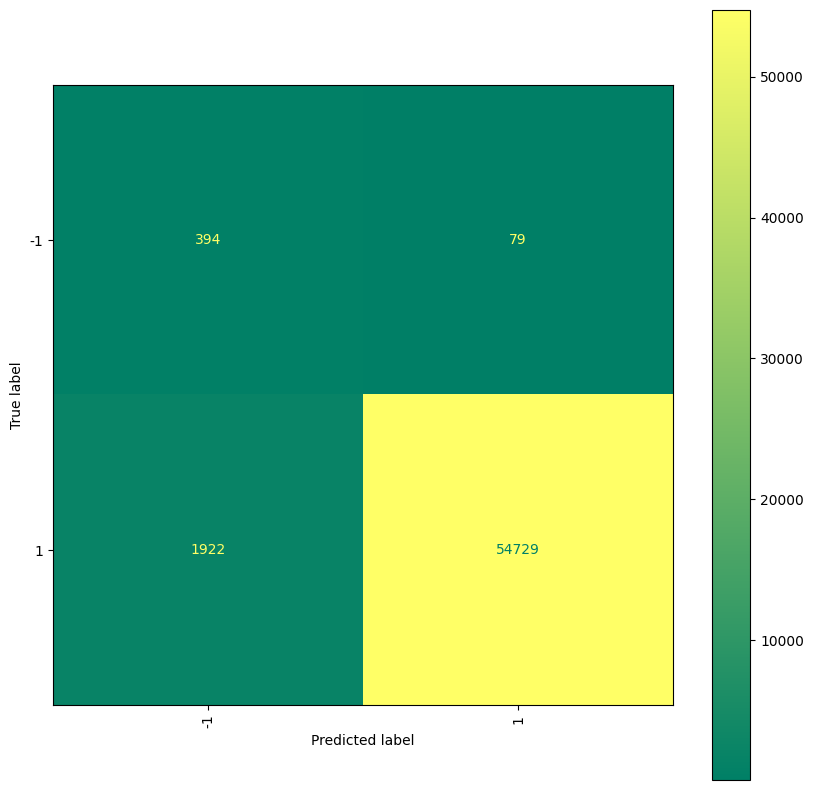

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred),
                              display_labels=[-1,1])

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')
plt.show()